# Module import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import scipy.linalg as lin
from scipy.optimize import minimize
from nftopt import nakanishi_fujii_todo
from util import *

In [2]:
from qiskit import *
from qiskit import Aer

In [4]:
def parametrized_quantum_circuit(circuit,param):
    p = copy.copy(param.tolist())
    for i in range(d):
        for j in range(n):
            circuit.rx(0.5*np.pi,j)
            circuit.rz( p.pop(0),j)
            circuit.rx(0.5*np.pi,j)
            circuit.rz( p.pop(0),j)
        for j in range(n-1):
            circuit.cz(j,j+1)
    for j in range(n):
        circuit.rx(0.5*np.pi,j)
        circuit.rz( p.pop(0),j)
        circuit.rx(0.5*np.pi,j)
        circuit.rz( p.pop(0),j)     
def parametrized_quantum_circuit_inv(circuit,param):
    p = copy.copy(param.tolist())
    for j in range(n):
        circuit.rz(  -p.pop(),n-j-1)
        circuit.rx(-0.5*np.pi,n-j-1)
        circuit.rz(  -p.pop(),n-j-1)
        circuit.rx(-0.5*np.pi,n-j-1)
    for i in range(d):
        for j in range(n-1):
            circuit.cz(j,j+1)
        for j in range(n):
            circuit.rz(  -p.pop(),n-j-1)
            circuit.rx(-0.5*np.pi,n-j-1)
            circuit.rz(  -p.pop(),n-j-1)
            circuit.rx(-0.5*np.pi,n-j-1)

In [28]:
class model_for_ssvqe:
    def __init__(self,observal,func,func_inv,n_param,n_sub):
        self.n_param  = n_param
        self.n_sub    = n_sub
        self.func     = func
        self.func_inv = func_inv
        self.obs      = observal
        self.weight   = 1 + np.arange(n_sub)[::-1]
        self.eval     = np.sort(np.linalg.eig(observal)[0].real)
        self.evec     = np.linalg.eig(observal)[1].T[np.argsort(np.linalg.eig(observal)[0].real)]
        self.backend  = Aer.get_backend('statevector_simulator')
        
        self.de       = []
        self.dc       = []
        self.dp       = []
        self.df       = []
        
    def measurement(self,phi):
        energy   = []
        fidelity = []
        for i in range(self.n_sub):
            circ = QuantumCircuit(n)
            circ.x(int(i))
            self.func(circ,phi)
            job = execute(circ, self.backend)
            result = job.result()
            outputstate = np.array(result.get_statevector(circ, decimals=3))
            energy.append(calculate_energy(outputstate,self.obs))
            fidelity.append(abs(outputstate.T.conj()@self.evec[i]))
        return np.array(energy),np.array(fidelity)
        
    def step(self,phi,evaluate=False,stop_signal=False):
        energy, fidelity   = self.measurement(phi)
        cost               = (self.weight*energy).sum()
        if evaluate:
            self.de.append(energy)
            self.dc.append(cost)
            self.dp.append(phi)
            self.df.append(fidelity)
        return cost
    
    def callback(self,phi):
        self.step(phi,evaluate=True)
    
    def plot(self,log=True):
        plt.rcParams['ytick.minor.visible'] = False
        plt.rcParams['xtick.top']           = True
        plt.rcParams['ytick.right']         = True
        plt.rcParams['ytick.minor.visible'] = False
        plt.rcParams['xtick.direction']     = 'in'
        plt.rcParams['ytick.direction']     = 'in'
        plt.rcParams['font.family']         = 'arial'
        plt.rcParams["mathtext.fontset"]    = 'stixsans'
        plt.rcParams['xtick.major.width']   = 0.5
        plt.rcParams['ytick.major.width']   = 0.5
        plt.rcParams['font.size']           = 16
        plt.rcParams['axes.linewidth']      = 1.0
        
        plt.figure(figsize=(7,5))
        plt.subplot(211)
        for i in range(self.n_sub):
            plt.plot(np.array(self.de).T[i],'-',label='SSVQE$(E_%s)$'%(i))
        plt.plot(self.eval[0]*np.ones(len(self.df)),'k--',label='Energy levels')  
        for i in self.eval[1:]:
            plt.plot(i*np.ones(len(self.df)),'k--')    
        plt.ylabel('Energy (Ha)')
        plt.tick_params(labelbottom=False, labelleft=True, labelright=False, labeltop=False)
        plt.xlim(0,len(self.df)-1)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
        plt.subplot(212)
        
        if log:
            for i in np.array(self.df).T:
                plt.plot(1-i)
            plt.yscale('log')
            plt.ylabel('Infidelity')
        else:
            for i in np.array(self.df).T:
                plt.plot(i)
            plt.ylim(0,1)
            plt.ylabel('Fidelity')
            
        iteration = np.linspace(0,len(self.df),5,dtype=np.int)
        iteration_label = iteration.astype(np.str)
        plt.xticks(iteration,iteration_label)
        plt.xlabel('# of iteration')
        plt.xlim(0,len(self.df)-1)
        plt.tight_layout()
        plt.show()

In [29]:
class model_for_svqs:
    def __init__(self,ssvqe):
        self.n_param  = ssvqe.n_param
        self.n_sub    = ssvqe.n_sub
        self.func     = ssvqe.func
        self.func_inv = ssvqe.func_inv
        self.backend  = ssvqe.backend
        self.de       = ssvqe.de[-1]
        self.dp       = ssvqe.dp[-1]
        
    def time_evolution(self,circuit,t):
        self.func_inv(circuit,self.dp)
        for i,j in zip(self.de,np.arange(self.n_sub)):
            circuit.rz(-i*t,int(j))
        self.func(circuit,self.dp)
        
    def measurement(self,state,observable,tlist):
        self.dm       = []
        circ = QuantumCircuit(n)
        for t in tlist:
            circ.initialize(params=state,qubits=circ.qubits)
            self.time_evolution(circ,t)
            job = execute(circ, self.backend)
            result = job.result()
            outputstate = np.array(result.get_statevector(circ, decimals=3))
            self.dm.append(calculate_energy(outputstate,observable))
    
    def plot(self):
        plt.rcParams['ytick.minor.visible'] = False
        plt.rcParams['xtick.top']           = True
        plt.rcParams['ytick.right']         = True
        plt.rcParams['ytick.minor.visible'] = False
        plt.rcParams['xtick.direction']     = 'in'
        plt.rcParams['ytick.direction']     = 'in'
        plt.rcParams['font.family']         = 'arial'
        plt.rcParams["mathtext.fontset"]    = 'stixsans'
        plt.rcParams['xtick.major.width']   = 0.5
        plt.rcParams['ytick.major.width']   = 0.5
        plt.rcParams['font.size']           = 16
        plt.rcParams['axes.linewidth']      = 1.0
        
        plt.figure(figsize=(5,5))
        plt.plot(tlist,self.dm,'k.-')
        plt.xlabel('Evolution time (ns)')
        plt.ylabel('Observable')
        plt.tight_layout()
        plt.show()

In [30]:
class model_for_csvqs:
    def __init__(self,ssvqe):
        self.n_param  = ssvqe.n_param
        self.n_sub    = ssvqe.n_sub
        self.func     = ssvqe.func
        self.func_inv = ssvqe.func_inv
        self.backend  = ssvqe.backend
        self.de       = ssvqe.de[-1]
        self.dp       = ssvqe.dp[-1]
        
    def control_time_evolution(self,circuit,t):
        self.func_inv(circuit,self.dp)
        for i,j in zip(self.de,np.arange(self.n_sub)):
            circuit.crz(-i*t,n,int(j))
        self.func(circuit,self.dp)
        
    def measurement(self,state,ancilla,observable,tlist):
        I = np.array([[1,0],[0,1]])
        state_with_ancilla      = np.kron(ancilla,state) # np.kron(state,ancilla)
        observable_with_ancilla = np.kron(I,observable) # np.kron(observable,I)
        self.dm       = []
        circ = QuantumCircuit(n+1)
        for t in tlist:
            circ.initialize(params=state_with_ancilla,qubits=circ.qubits)
            self.control_time_evolution(circ,t)
            job = execute(circ, self.backend)
            result = job.result()
            outputstate = np.array(result.get_statevector(circ, decimals=3))
            self.dm.append(calculate_energy(outputstate,observable_with_ancilla))
    
    def plot(self):
        plt.rcParams['ytick.minor.visible'] = False
        plt.rcParams['xtick.top']           = True
        plt.rcParams['ytick.right']         = True
        plt.rcParams['ytick.minor.visible'] = False
        plt.rcParams['xtick.direction']     = 'in'
        plt.rcParams['ytick.direction']     = 'in'
        plt.rcParams['font.family']         = 'arial'
        plt.rcParams["mathtext.fontset"]    = 'stixsans'
        plt.rcParams['xtick.major.width']   = 0.5
        plt.rcParams['ytick.major.width']   = 0.5
        plt.rcParams['font.size']           = 16
        plt.rcParams['axes.linewidth']      = 1.0
        
        plt.figure(figsize=(5,5))
        plt.plot(tlist,self.dm,'k.-')
        plt.xlabel('Evolution time (ns)')
        plt.ylabel('Observable')
        plt.tight_layout()
        plt.show()

# Subspace-search variational quantum eigensolver (SSVQE)

Generating fully-connected transversal Ising Hamiltonian

In [31]:
n           = 2
hamiltonian = 0
ci  = np.random.random(n)
cij = np.random.random([n,n])
for i in range(n):
    for j in range(n):
        if i == j:
            hamiltonian += ci[i]*tensor([I]*i+[X]+[I]*(n-i-1))
        elif j > i:
            hamiltonian += ci[i]*tensor([I]*i+[Z]+[I]*(j-i-1)+[Z]+[I]*(n-j-1))

<img src="figures/ssvqe.png" style="width: 500px;">

Learn parameterized quantum circuit by SSVQS (https://arxiv.org/abs/1810.09434) with sequential minimal optimization (https://arxiv.org/abs/1903.12166)

In [32]:
d        = 3
n_sub    = 2
func     = parametrized_quantum_circuit
func_inv = parametrized_quantum_circuit_inv
n_param  = 2*n*(d+1)
ssvqe    = model_for_ssvqe(hamiltonian,func,func_inv,n_param,n_sub)

In [33]:
res = minimize(
    ssvqe.step,
    np.random.random(n_param),
    options={'maxfev': 500},
    method=nakanishi_fujii_todo,
    callback=ssvqe.callback
)

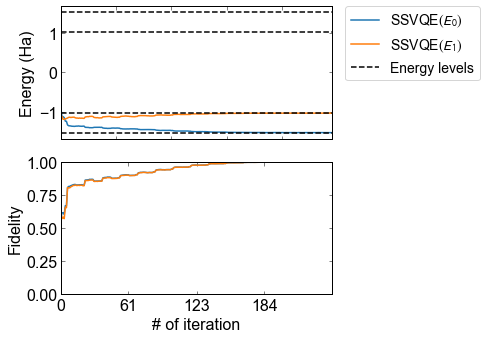

In [34]:
ssvqe.plot(log=False)

# Subspace variational quantum simulator (SVQS)

<img src="figures/svqs.png" style="width: 500px;">

Generating superposition state in eigen basis by hand

You have another approach not to need it (detail in https://arxiv.org/abs/1904.08566)

In [35]:
state = []
for i in range(n):
    circ = QuantumCircuit(n)
    circ.x(int(i))
    parametrized_quantum_circuit(circ,ssvqe.dp[-1])
    job = execute(circ, Aer.get_backend('statevector_simulator'))
    result = job.result()
    state.append(np.array(result.get_statevector(circ, decimals=3)))
state = np.array(state[0] + state[1])
state = state/np.linalg.norm(state)

In [36]:
observable = tensor([Z]+[I])

Run subspace variational quantum simulator (https://arxiv.org/abs/1904.08566)

In [37]:
tlist = np.linspace(0,10,21)
svqs  = model_for_svqs(ssvqe)
svqs.measurement(state,observable,tlist)

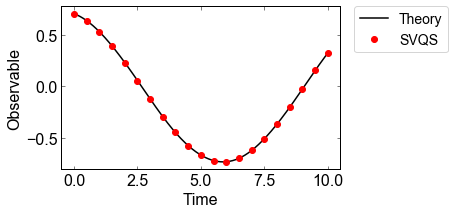

In [38]:
dm = []
plot_tlist = np.linspace(0,10,501)
for t in plot_tlist:
    out = lin.expm(-1j*hamiltonian*t)@state
    obs = (out.T.conj()@observable@out).real
    dm.append(obs)
plt.figure(figsize=(5,3))
plt.plot(plot_tlist,dm,'k-',label='Theory')
plt.plot(tlist,svqs.dm,'ro',label='SVQS')
plt.xlabel('Time')
plt.ylabel('Observable')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
plt.show()

# Controled subspace variational quantum simulator (CSVQS)

<img src="figures/csvqs.png" style="width: 600px;">

In [39]:
# when ancilla = |0>
ancilla = np.array([1,0])
tlist   = np.linspace(0,10,21)
csvqs0  = model_for_csvqs(ssvqe)
csvqs0.measurement(state,ancilla,observable,tlist)

# when ancilla = |1>
ancilla = np.array([0,1])
csvqs1  = model_for_csvqs(ssvqe)
csvqs1.measurement(state,ancilla,observable,tlist)

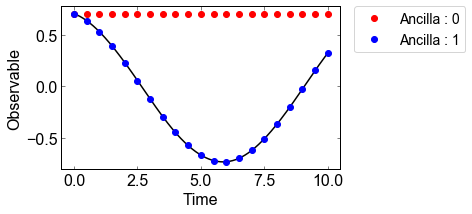

In [40]:
dm = []
plot_tlist = np.linspace(0,10,501)
for t in plot_tlist:
    out = lin.expm(-1j*hamiltonian*t)@state
    obs = (out.T.conj()@observable@out).real
    dm.append(obs)
plt.figure(figsize=(5,3))
plt.plot(plot_tlist,dm,'k-')
plt.plot(tlist,csvqs0.dm,'ro',label='Ancilla : 0')
plt.plot(tlist,csvqs1.dm,'bo',label='Ancilla : 1')
plt.xlabel('Time')
plt.ylabel('Observable')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=14)
plt.show()